In [1]:
import string,re
import pandas as pd
import contractions
import nltk
import seaborn as sns
import matplotlib.pyplot as plt

from nltk.corpus import stopwords


pd.set_option('display.max_colwidth', 400)
pd.set_option('display.max_rows', 1000) 

In [2]:
df_labelled = pd.read_csv("./dataset/vax_tweets_sentiment.csv")

In [3]:
df_labelled.head()

,Unnamed: 0,id,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,retweets,favorites,is_retweet,sentiment,orig_text
0,0,1340539111971516416,Rachel Roh,"La Crescenta-Montrose, CA","Aggregator of Asian American news; scanning diverse sources 24/7/365. RT's, Follows and 'Likes' will fuel me 👩‍💻",2009-04-08 17:52:46,405,1692,3247,False,2020-12-20,Same folks said daikon paste could treat a cytokine storm,['PfizerBioNTech'],Twitter for Android,0,0.0,False,neutral,Same folks said daikon paste could treat a cytokine storm #PfizerBioNTech https://t.co/xeHhIMg1kF
1,1,1338158543359250433,Albert Fong,"San Francisco, CA","Marketing dude, tech geek, heavy metal & '80s music junkie. Fascinated by meteorology and all things in the cloud. Opinions are my own.",2009-09-21 15:27:30,834,666,178,False,2020-12-13,"While the world has been on the wrong side of history this year, hopefully, the biggest vaccination effort we've ev",NaN,Twitter Web App,1,1.0,False,positive,"While the world has been on the wrong side of history this year, hopefully, the biggest vaccination effort we've ev… https://t.co/dlCHrZjkhm"
2,2,1337858199140118533,eli🇱🇹🇪🇺👌,Your Bed,"heil, hydra 🖐☺",2020-06-25 23:30:28,10,88,155,False,2020-12-12,Russian vaccine is created to last 2-4 years,"['coronavirus', 'SputnikV', 'AstraZeneca', 'PfizerBioNTech', 'Moderna', 'Covid_19']",Twitter for Android,0,0.0,False,neutral,#coronavirus #SputnikV #AstraZeneca #PfizerBioNTech #Moderna #Covid_19 Russian vaccine is created to last 2-4 years… https://t.co/ieYlCKBr8P
3,3,1337855739918835717,Charles Adler,"Vancouver, BC - Canada","Hosting ""CharlesAdlerTonight"" Global News Radio Network. Weeknights 7 Pacific-10 Eastern - Email comments/ideas to charles@charlesadlertonight.ca",2008-09-10 11:28:53,49165,3933,21853,True,2020-12-12,"Facts are immutable, Senator, even when you're not ethically sturdy enough to acknowledge them. (1) You were born i",NaN,Twitter Web App,446,2129.0,False,neutral,"Facts are immutable, Senator, even when you're not ethically sturdy enough to acknowledge them. (1) You were born i… https://t.co/jqgV18kch4"
4,4,1337854064604966912,Citizen News Channel,NaN,Citizen News Channel bringing you an alternative news source from citizen journalists that haven't sold out. Real news & real views,2020-04-23 17:58:42,152,580,1473,False,2020-12-12,Explain to me again why we need a vaccine,"['whereareallthesickpeople', 'PfizerBioNTech']",Twitter for iPhone,0,0.0,False,neutral,Explain to me again why we need a vaccine @BorisJohnson @MattHancock #whereareallthesickpeople #PfizerBioNTech… https://t.co/KxbSRoBEHq


In [4]:
df_labelled.isnull().sum()

Unnamed: 0             0
id                     3
user_name              3
user_location       6853
user_description    2063
user_created           4
user_followers         4
user_friends           4
user_favourites        5
user_verified          5
date                   5
text                   5
hashtags            6213
source                28
retweets               6
favorites              7
is_retweet             7
sentiment              7
orig_text              7
dtype: int64

In [5]:
df_labelled.shape

(29452, 19)

In [6]:
#Drop tweets with null values
df_labelled = df_labelled[df_labelled["orig_text"].notnull()]

In [7]:
df_labelled.isnull().sum()

Unnamed: 0             0
id                     0
user_name              0
user_location       6850
user_description    2060
user_created           0
user_followers         0
user_friends           0
user_favourites        0
user_verified          0
date                   0
text                   0
hashtags            6207
source                22
retweets               0
favorites              0
is_retweet             0
sentiment              0
orig_text              0
dtype: int64

In [8]:
#Drop index column from the csv file
df_labelled.drop(columns=['Unnamed: 0'], inplace=True)

In [9]:
df_labelled.shape

(29445, 18)

In [10]:
#Count positive,negative & neutral sentiment
df_labelled['sentiment'].value_counts()

neutral     18566
positive     6431
negative     4448
Name: sentiment, dtype: int64

In [11]:
#Find duplicated tweets from the same username
df_labelled[df_labelled.duplicated(['orig_text','user_name'],keep = False)].sort_values(by ='text' )

,id,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,retweets,favorites,is_retweet,sentiment,orig_text
14470,1366246561089396741,@shalinisharma87,patna,"love the beauty of the nature and I am beautiful too, student of commerce, love to sing,dance and travel at new places",2021-02-01 15:51:16,146,763,303,False,2021-03-01,of Bharat Biotech,"['SastaBhiKargarBhi', 'Covaxin']",Twitter Web App,0,0.0,False,neutral,@idnani_nandini #SastaBhiKargarBhi #Covaxin of Bharat Biotech
14459,1366246841226985478,@shalinisharma87,patna,"love the beauty of the nature and I am beautiful too, student of commerce, love to sing,dance and travel at new places",2021-02-01 15:51:16,146,763,303,False,2021-03-01,of Bharat Biotech,"['SastaBhiKargarBhi', 'Covaxin']",Twitter Web App,0,0.0,False,neutral,@idnani_nandini #SastaBhiKargarBhi #Covaxin of Bharat Biotech
9067,1361445158395531266,Victor Hugo del Sol,NaN,"Financial markets, Derivatives trader, crypto degen, Java & Python copy paster, adrenaline junkie and good vibes master.",2009-07-24 06:34:52,288,1682,18722,False,2021-02-15,Dr faucii = Also know as the NEW angel of death version of,"['modernA', 'JosefMengele']",Twitter for iPhone,0,0.0,False,neutral,@WHO @DrTedros Dr faucii = Also know as “the NEW angel of death” #modernA version of #JosefMengele
9066,1361445186048524292,Victor Hugo del Sol,NaN,"Financial markets, Derivatives trader, crypto degen, Java & Python copy paster, adrenaline junkie and good vibes master.",2009-07-24 06:34:52,288,1682,18722,False,2021-02-15,Dr faucii = Also know as the NEW angel of death version of,"['modernA', 'JosefMengele']",Twitter for iPhone,2,2.0,False,neutral,@WHO @DrTedros Dr faucii = Also know as “the NEW angel of death” #modernA version of #JosefMengele
13152,1366230607324356609,Always Wild,India,Aspiring Programmer / Techie/ Technology / Science / News -\n\nStay tune for important #BreakingNews updates.,2020-05-14 05:44:26,4,3,5,False,2021-03-01,": Sister P Niveda, from administered to PM .","['BreakingNews', 'Puducherry', 'COVAXIN', 'BharatBiotech', 'NarendraModi']",Twitter for Android,0,0.0,False,neutral,"#BreakingNews : Sister P Niveda, from #Puducherry, administered #COVAXIN #BharatBiotech to PM #NarendraModi ."
13116,1366233201182527490,Always Wild,India,Aspiring Programmer / Techie/ Technology / Science / News -\n\nStay tune for important #BreakingNews updates.,2020-05-14 05:44:26,4,3,5,False,2021-03-01,": Sister P Niveda, from administered to PM .","['BreakingNews', 'Puducherry', 'COVAXIN', 'BharatBiotech', 'NarendraModi']",Twitter for Android,0,0.0,False,neutral,"#BreakingNews : Sister P Niveda, from #Puducherry, administered #COVAXIN #BharatBiotech to PM #NarendraModi ."
22347,1367943771489505283,Frontend.LA,NaN,"When we reach 1M Followers, we'll hire only from our followers list.",2017-06-14 21:47:14,184,25,45,False,2021-03-05,Post jobs for free on,['Moderna'],FrontendLA,0,0.0,False,neutral,#Moderna Post jobs for free on https://t.co/Jxbtzryhtg
5962,1358909490654023681,Frontend.LA,NaN,"When we reach 1M Followers, we'll hire only from our followers list.",2017-06-14 21:47:14,141,25,43,False,2021-02-08,Post jobs for free on,['Moderna'],FrontendLA,0,0.0,False,neutral,#Moderna Post jobs for free on https://t.co/Jxbtzryhtg
4499,1353407921665826816,TheRag,Ragbag Of Reviews And Insights,siya@mmvii.co.za/heelextension@gmail.com,2019-02-11 18:11:23,485,5004,67,False,2021-01-24,Vaccine Rollout Needs Spark Even More Innovation,"['Covid19', 'Ergotron', 'VaccinationCart', 'Pfizer', 'PfizerBioNTech']",Twitter Web App,1,0.0,False,positive,#Covid19 Vaccine Rollout Needs Spark Even More Innovation https://t.co/EBaYqJexm1 #Ergotron #VaccinationCart #Pfizer #PfizerBioNTech
4531,1353959514614202368,TheRag,Ragbag Of Reviews And Insights,siya@mmvii.co.za/heelextension@gmail.com,2019-02-11 18:11:23,484,5004,70,False,2021-01-26,Vaccine Rollout Needs Spark Even More Innovation,"['Covid19', '

In [12]:
#Drop duplicated tweets
df_labelled = df_labelled.drop_duplicates('orig_text')
df_labelled.reset_index(drop=True, inplace=True)

In [13]:
df_labelled.shape

(29419, 18)

In [14]:
#Cleaning function

def cleaned_text(text):
    #Expand contractions. I'll -> I will
    text = contractions.fix(text) 
    
    #Remove hashtag
    text = re.sub("(#[A-Za-z0-9_]+)","", text)
    
    #Remove website link
    text = re.sub('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+#]|[!*\(\),]|'\
                   '(?:%[0-9a-fA-F][0-9a-fA-F]))+','', text)
    
    #Remove tweet handle
    text = re.sub("(@[A-Za-z0-9_]+)","", text)
    
    #Remove /n
    text = re.sub("\n"," ", text)
    
    #Remove multiple dots
    text = re.sub(r'\.+', ".", text)
    
    #Remove '.' ',' '-' and '@' between words
    text = re.sub(r'\b[.,@-]\b', " ", text)
    
    #Remove punctuations
    text = re.sub(r'[^\w\s\#]', '', text)
    
    #Remove special characters
    text = re.sub(r'[^A-Za-z0-9 ]+','', text)
    
    #Remove digits
    text = re.sub(r'\d+','', text)
        
    #Remove leading and trailing spaces
    text = re.sub(r"^\s+|\s+$", "", text)
    
    #Remove multiple whitespace 
    text = re.sub(r"\s+", " ", text)
    
    #Convert to lower case
    text = text.lower()
    
    return text

In [15]:
#Copy original text and sentiment column into new dataframe

df_preprocess = pd.DataFrame(df_labelled['orig_text'])
df_preprocess['sentiment'] = df_labelled['sentiment']
df_preprocess['user_name'] = df_labelled['user_name']
df_preprocess['date'] = df_labelled['date']
df_preprocess['hashtags'] = df_labelled['hashtags']

df_preprocess.head(1000)

,orig_text,sentiment,user_name,date,hashtags
0,Same folks said daikon paste could treat a cytokine storm #PfizerBioNTech https://t.co/xeHhIMg1kF,neutral,Rachel Roh,2020-12-20,['PfizerBioNTech']
1,"While the world has been on the wrong side of history this year, hopefully, the biggest vaccination effort we've ev… https://t.co/dlCHrZjkhm",positive,Albert Fong,2020-12-13,NaN
2,#coronavirus #SputnikV #AstraZeneca #PfizerBioNTech #Moderna #Covid_19 Russian vaccine is created to last 2-4 years… https://t.co/ieYlCKBr8P,neutral,eli🇱🇹🇪🇺👌,2020-12-12,"['coronavirus', 'SputnikV', 'AstraZeneca', 'PfizerBioNTech', 'Moderna', 'Covid_19']"
3,"Facts are immutable, Senator, even when you're not ethically sturdy enough to acknowledge them. (1) You were born i… https://t.co/jqgV18kch4",neutral,Charles Adler,2020-12-12,NaN
4,Explain to me again why we need a vaccine @BorisJohnson @MattHancock #whereareallthesickpeople #PfizerBioNTech… https://t.co/KxbSRoBEHq,neutral,Citizen News Channel,2020-12-12,"['whereareallthesickpeople', 'PfizerBioNTech']"
5,Does anyone have any useful advice/guidance for whether the COVID vaccine is safe whilst breastfeeding?… https://t.co/EifsyQoeKN,neutral,Dee,2020-12-12,NaN
6,"it is a bit sad to claim the fame for success of #vaccination on patriotic competition between USA, Canada, UK and… https://t.co/IfMrAyGyTP",negative,Gunther Fehlinger,2020-12-12,['vaccination']
7,There have not been many bright days in 2020 but here are some of the best \n1. #BidenHarris winning #Election2020… https://t.co/77u4f8XXfx,positive,Dr.Krutika Kuppalli,2020-12-12,"['BidenHarris', 'Election2020']"
8,Covid vaccine; You getting it?\n\n #CovidVaccine #covid19 #PfizerBioNTech #Moderna,neutral,Erin Despas,2020-12-12,"['CovidVaccine', 'covid19', 'PfizerBioNTech', 'Moderna']"
9,"#CovidVaccine \n\nStates will start getting #COVID19Vaccine Monday, #US says \n#pakustv #NYC #Healthcare #GlobalGoals… https://t.co/MksOvBvs5w",neutral,Ch.Amjad Ali,2020-12-12,"['CovidVaccine', 'COVID19Vaccine', 'US', 'pakustv', 'NYC', 'Healthcare', 'GlobalGoals']"


In [16]:
#Run cleaning function and copy cleanted text into cleaned_text column
df_preprocess['cleaned_text'] = df_preprocess['orig_text'].transform(cleaned_text)

In [17]:
df_preprocess.head(1000)

,orig_text,sentiment,user_name,date,hashtags,cleaned_text
0,Same folks said daikon paste could treat a cytokine storm #PfizerBioNTech https://t.co/xeHhIMg1kF,neutral,Rachel Roh,2020-12-20,['PfizerBioNTech'],same folks said daikon paste could treat a cytokine storm
1,"While the world has been on the wrong side of history this year, hopefully, the biggest vaccination effort we've ev… https://t.co/dlCHrZjkhm",positive,Albert Fong,2020-12-13,NaN,while the world has been on the wrong side of history this year hopefully the biggest vaccination effort we have ev
2,#coronavirus #SputnikV #AstraZeneca #PfizerBioNTech #Moderna #Covid_19 Russian vaccine is created to last 2-4 years… https://t.co/ieYlCKBr8P,neutral,eli🇱🇹🇪🇺👌,2020-12-12,"['coronavirus', 'SputnikV', 'AstraZeneca', 'PfizerBioNTech', 'Moderna', 'Covid_19']",russian vaccine is created to last years
3,"Facts are immutable, Senator, even when you're not ethically sturdy enough to acknowledge them. (1) You were born i… https://t.co/jqgV18kch4",neutral,Charles Adler,2020-12-12,NaN,facts are immutable senator even when you are not ethically sturdy enough to acknowledge them you were born i
4,Explain to me again why we need a vaccine @BorisJohnson @MattHancock #whereareallthesickpeople #PfizerBioNTech… https://t.co/KxbSRoBEHq,neutral,Citizen News Channel,2020-12-12,"['whereareallthesickpeople', 'PfizerBioNTech']",explain to me again why we need a vaccine
5,Does anyone have any useful advice/guidance for whether the COVID vaccine is safe whilst breastfeeding?… https://t.co/EifsyQoeKN,neutral,Dee,2020-12-12,NaN,does anyone have any useful adviceguidance for whether the covid vaccine is safe whilst breastfeeding
6,"it is a bit sad to claim the fame for success of #vaccination on patriotic competition between USA, Canada, UK and… https://t.co/IfMrAyGyTP",negative,Gunther Fehlinger,2020-12-12,['vaccination'],it is a bit sad to claim the fame for success of on patriotic competition between usa canada uk and
7,There have not been many bright days in 2020 but here are some of the best \n1. #BidenHarris winning #Election2020… https://t.co/77u4f8XXfx,positive,Dr.Krutika Kuppalli,2020-12-12,"['BidenHarris', 'Election2020']",there have not been many bright days in but here are some of the best winning
8,Covid vaccine; You getting it?\n\n #CovidVaccine #covid19 #PfizerBioNTech #Moderna,neutral,Erin Despas,2020-12-12,"['CovidVaccine', 'covid19', 'PfizerBioNTech', 'Moderna']",covid vaccine you getting it
9,"#CovidVaccine \n\nStates will start getting #COVID19Vaccine Monday, #US says \n#pakustv #NYC #Healthcare #GlobalGoals… https://t.co/MksOvBvs5w",neutral,Ch.Amjad Ali,2020-12-12,"['CovidVaccine', 'COVID19Vaccine', 'US', 'pakustv', 'NYC', 'Healthcare', 'GlobalGoals']",states will start getting monday says


In [18]:
#List predifined stopwords by NLTK
nltk.download('stopwords')
stop_words = stopwords.words('english')
print(stop_words)

[nltk_data] Downloading package stopwords to /home/fauzi/nltk_data...


['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

[nltk_data]   Package stopwords is already up-to-date!


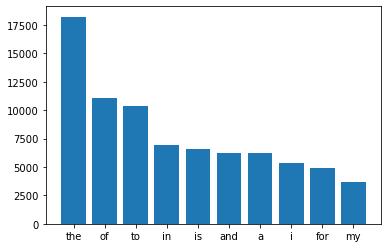

In [19]:
#Plot top NLTK stopwords in dataset

def plot_top_stopwords_barchart(text):
    stop=set(stopwords.words('english'))
    
    new= text.str.split()
    new=new.values.tolist()
    corpus=[word for i in new for word in i]
    from collections import defaultdict
    dic=defaultdict(int)
    for word in corpus:
        if word in stop:
            dic[word]+=1
            
    top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10] 
    x,y=zip(*top)

    plt.bar(x,y)
    
plot_top_stopwords_barchart(df_preprocess['cleaned_text'])

In [20]:
#Define stop words and remove stop words function

def rm_stopwords(text):
    
    stop_words=['in','of','at','a','the','to','is','and','i','for','my','on','it','you','this','are','be','as',
           'an', 'all', 'if', 'our', 'ours', 'ourselves', 'was', 'that', 'that’s','there','me','they','them',
            'themselves','will','which','who','who’s','what','she','her','herself','he','him','his','himself',
            'we','by','those','these','your','yours','you’re','yourself', 'yourselves','or','other','off',
            'their','theirs','then','where','where’s','when','when’s','its','itself','so','onto','every',
            'each','been','being','having','here','here’s','well','say','says','said','why','how','i’m','whom',
            'us', 'myself','s','am','amp','have','has','had','with','do']
    
    cleaned_tokens = []
    for i in text.split():
        if len(i) > 1 and i not in stop_words:
            cleaned_tokens.append(i)
            
    return ' '.join(cleaned_tokens)

In [21]:
df_preprocess['cleaned_text'] = df_preprocess['cleaned_text'].transform(rm_stopwords)

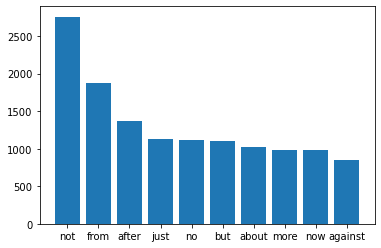

In [22]:
plot_top_stopwords_barchart(df_preprocess['cleaned_text'])

In [23]:
#Remove 0 word tweets after preprocessed

null_cleanedtext = []

for a,b in zip(df_preprocess.cleaned_text, df_preprocess.index): 
    
    if len(a.split()) == 0:
        null_cleanedtext.append(b)

In [24]:
#List all 0 word tweets
df_preprocess[df_preprocess.index.isin(null_cleanedtext)]

,orig_text,sentiment,user_name,date,hashtags,cleaned_text
190,It’s here. #Covid_19 #CovidVaccine #PfizerBioNTech https://t.co/1E0bcR8Lig,neutral,IN,2020-12-13,"['Covid_19', 'CovidVaccine', 'PfizerBioNTech']",
334,@MJMoore77 @yvettedoc50 @J_bagpuss @EllzSummary @fentonaw @OldburySally @DocSandip @DrNeenaJha @DrPeterWeeks1… https://t.co/QoSOb9MqRO,neutral,Simon Hodes ⬅️2m➡️ 😷,2020-12-15,NaN,
545,#COVID19 #COVID19USA #COVID19Vaccine #PfizerBioNTech #PfizerVaccine \n#PresidentElectJoeBiden \n#JoeBiden @JoeBiden… https://t.co/rXR216U7tV,neutral,Jacqueline Roche,2020-12-16,"['COVID19', 'COVID19USA', 'COVID19Vaccine', 'PfizerBioNTech', 'PfizerVaccine', 'PresidentElectJoeBiden', 'JoeBiden']",
662,#keepingupwithralph #pfizerbiontech #vaccine #fcovid19 #dignityhealth #californiahospitalmedicalcenter #healer… https://t.co/ympJVfZVbm,neutral,Ralph Mayer,2020-12-18,"['keepingupwithralph', 'pfizerbiontech', 'vaccine', 'fcovid19', 'dignityhealth', 'californiahospitalmedicalcenter', 'healer']",
671,#PfizerCOVIDvaccine \n#PfizerBioNTech \n#Pfizervaccine \n#CovidVaccines \n#CovidVaccine \n#coronavirus \n#Covid_19… https://t.co/Ux6olY2AfO,neutral,Demi P. #Georgia #Vote #OssoffandWarnockForSenate,2020-12-17,"['PfizerCOVIDvaccine', 'PfizerBioNTech', 'Pfizervaccine', 'CovidVaccines', 'CovidVaccine', 'coronavirus', 'Covid_19']",
849,#COVAX #ThePeoplesVaccine #COVID19 #Moderna #SputnikV #PfizerBioNTech #Pfizervaccine #Sinovac #Sinopharm… https://t.co/SkemQRqIa7,neutral,Christopher Burke,2020-12-18,"['COVAX', 'ThePeoplesVaccine', 'COVID19', 'Moderna', 'SputnikV', 'PfizerBioNTech', 'Pfizervaccine', 'Sinovac', 'Sinopharm']",
1166,#Health #DrFauci #COVID19 #coronavirus #vaccine #corona #vaccination #vaccines #VaccinesWork #CDC #FDA… https://t.co/ByV517QZp3,neutral,Carol Hafner for Congress,2020-12-24,"['Health', 'DrFauci', 'COVID19', 'coronavirus', 'vaccine', 'corona', 'vaccination', 'vaccines', 'VaccinesWork', 'CDC', 'FDA']",
1418,#22dicembre #VaccinoAntiCovid #vaccino #vaccinoCovid #Pfizer #PfizerBioNTech #Italia #COVID19 #COVID19italia… https://t.co/yag6k5xt6H,neutral,Roberto,2020-12-22,"['22dicembre', 'VaccinoAntiCovid', 'vaccino', 'vaccinoCovid', 'Pfizer', 'PfizerBioNTech', 'Italia', 'COVID19', 'COVID19italia']",
1431,#Covid19UK #COVID19 ⁦@BBCNews⁩ ⁦@BBCBreaking⁩ ⁦@BBCWorld⁩ ⁦@SkyNews⁩ ⁦@SkyNewsBreak⁩ ⁦@CNN⁩ ⁦@FoxNews⁩ ⁦@LBCNews ⁦… https://t.co/lESV3Qfq5p,neutral,demonspeedracer,2020-12-22,"['Covid19UK', 'COVID19']",
1502,#UKcovid #UKlockdown #ReinoUnido #MutacionCovid19 #mutation #coronavirus #SARS_CoV_2 #Covid_19 #COVID19 #COVID20… https://t.co/UxcjIuCRgr,neutral,Alex,2020-12-22,"['UKcovid', 'UKlockdown', 'ReinoUnido', 'MutacionCovid19', 'mutation', 'coronavirus', 'SARS_CoV_2', 'Covid_19', 'COVID19', 'COVID20']",


In [25]:
print("Total tweets with 0 word: ",len(null_cleanedtext))
print("Current dataset shape: ",df_preprocess.shape)

Total tweets with 0 word:  211
Current dataset shape:  (29419, 6)


In [26]:
#Remove rows with tweets with 0 word
df_preprocess = df_preprocess[~df_preprocess.index.isin(null_cleanedtext)]

print("Current dataset shape: ",df_preprocess.shape)

Current dataset shape:  (29208, 6)


In [27]:
#Find duplicated 'cleaned_text' from the same username
df_preprocess[df_preprocess.duplicated(['cleaned_text','user_name'],keep = False)].sort_values(by ='orig_text')

,orig_text,sentiment,user_name,date,hashtags,cleaned_text
3534,"""Protection"" and ""efficacy"" need to be clarified. Antibodies need to be neutralizing and must not induce antibody… https://t.co/36GdZF4AV6",neutral,Fiore DiNotte,2021-01-14,NaN,protection efficacy need clarified antibodies need neutralizing must not induce antibody
3535,"""Protection"" and ""efficacy"" need to be clarified. Antibodies need to be neutralizing and must not induce antibody… https://t.co/c6muvhIm2N",neutral,Fiore DiNotte,2021-01-14,NaN,protection efficacy need clarified antibodies need neutralizing must not induce antibody
4918,"""Vaccine Hoarding"" Under Spotlight At The #UnitedNations https://t.co/GIa2W4wRxn #PfizerBioNTech #COVAX… https://t.co/0WCODkWend",neutral,TheRag,2021-01-30,"['UnitedNations', 'PfizerBioNTech', 'COVAX']",vaccine hoarding under spotlight
4707,"""Vaccine Hoarding"" Under Spotlight At The #UnitedNations https://t.co/GIa2W4wRxn #PfizerBioNTech #COVAX… https://t.co/0izpI9oI0w",neutral,TheRag,2021-01-28,"['UnitedNations', 'PfizerBioNTech', 'COVAX']",vaccine hoarding under spotlight
4629,"""Vaccine Hoarding"" Under Spotlight At The #UnitedNations https://t.co/GIa2W4wRxn #PfizerBioNTech #COVAX… https://t.co/6mCeZT4skM",neutral,TheRag,2021-01-26,"['UnitedNations', 'PfizerBioNTech', 'COVAX']",vaccine hoarding under spotlight
...,...,...,...,...,...,...
24141,🚑🏥#COVID19 vaccination drive in Cambodia 🇰🇭 \n💉💉#Sinopharm from 10 February-13 March 2021\n💉💉#Covishield from 04 Marc… https://t.co/bEiIiw7aQ2,neutral,Office of Cambodia's Prime Minister 🇰🇭,2021-03-14,"['COVID19', 'Sinopharm', 'Covishield']",vaccination drive cambodia from february march from marc
19768,🚑🏩#COVID19 vaccination drive in Cambodia 🇰🇭 \n💉💉#Sinopharm from 10 February-09 March 2021\n💉💉#Covishield from 04 Marc… https://t.co/zOvgQx4cho,neutral,Office of Cambodia's Prime Minister 🇰🇭,2021-03-10,"['COVID19', 'Sinopharm', 'Covishield']",vaccination drive cambodia from february march from marc
19738,🚑🏩#COVID19 vaccination drive in Cambodia 🇰🇭 \n💉💉#Sinopharm from 10 February-10 March 2021\n💉💉#Covishield from 04 Marc… https://t.co/qdOfNBVL6M,neutral,Office of Cambodia's Prime Minister 🇰🇭,2021-03-11,"['COVID19', 'Sinopharm', 'Covishield']",vaccination drive cambodia from february march from marc
24855,🚨Need your MODERNA FIRST-DOSE shot? Call us to book an appointment! Hurry! Call (318) 325-1092 &amp; press 0 for an app… https://t.co/ZyL2g3GNeL,neutral,GO CARE Community Health Center,2021-03-15,NaN,need moderna first dose shot call book appointment hurry call press app


In [28]:
#Drop duplicated 'cleaned_text' from the same username
df_preprocess = df_preprocess.drop_duplicates('cleaned_text')
df_preprocess.reset_index(drop=True, inplace=True)
print("Current dataset shape: ",df_preprocess.shape)

Current dataset shape:  (26713, 6)


In [29]:
#Count positive,negative & neutral sentiment
df_preprocess['sentiment'].value_counts()

neutral     16651
positive     5933
negative     4129
Name: sentiment, dtype: int64

<AxesSubplot:xlabel='sentiment', ylabel='count'>

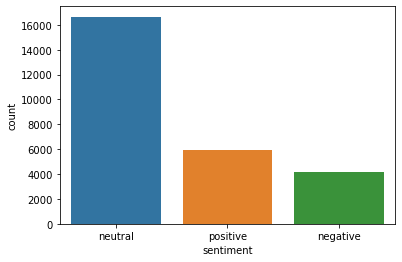

In [30]:
sns.countplot(x=df_preprocess['sentiment'])

In [31]:
#Export to csv

df_preprocess.to_csv("./dataset/vax_tweets_sentiment_cleaned.csv", index=False)